### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
# Importing required libraries 
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers import Concatenate

In [2]:
# This code snippet is copied from DenseNet - cifar10.ipynb, provided by Applied AI
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 10
num_filter = 42
compression = 0.5
dropout_rate = 0

In [3]:
# This code snippet is copied from DenseNet - cifar10.ipynb, provided by Applied AI
# load dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]
# one hot encode target values
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
X_train.shape

(50000, 32, 32, 3)

In [5]:
X_test.shape

(10000, 32, 32, 3)

In [6]:
y_train.shape

(50000, 10)

In [7]:
y_test.shape

(10000, 10)

#Ref - https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
![](cnn_cifr_1.png)

In [8]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [9]:
X_train,X_test=prep_pixels(X_train,X_test)

In [10]:
# This code snippet is copied from DenseNet - cifar10.ipynb, provided by Applied AI
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [11]:
# This code snippet is copied from DenseNet - cifar10.ipynb, provided by Applied AI
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [12]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 42)   1134        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 42)   168         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 42)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

#Ref - https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
![](cnn_cifr_2.png)

In [14]:
# plot diagnostic learning curves
from matplotlib import pyplot
%matplotlib inline
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='red', label='train')
    pyplot.plot(history.history['val_loss'], color='blue', label='test')
    pyplot.grid(alpha=0.8)
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='red', label='train')
    pyplot.plot(history.history['val_accuracy'], color='blue', label='test')
    pyplot.grid(alpha=0.8)
    pyplot.show()
    pyplot.close()

In [15]:
"""https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/"""
def run_test_harness(trainX, testX, trainY, testY, a, b, training_model, name):
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.25, height_shift_range=0.25, 
                                 horizontal_flip=True, fill_mode='nearest', zoom_range=0.10)
    final_train = datagen.flow(trainX, trainY, batch_size=a)
    history = training_model.fit_generator(final_train, epochs=b, validation_data=(testX, testY), verbose=1)
    _, acc = training_model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    summarize_diagnostics(history)
    x = "/content/After-"+name+"-epochs.h5"
    training_model.save(x)

Epoch 1/15
391/391 [==============================] - 99s 223ms/step - loss: 1.8718 - accuracy: 0.3165 - val_loss: 2.3281 - val_accuracy: 0.2624
Epoch 2/15
391/391 [==============================] - 86s 220ms/step - loss: 1.3563 - accuracy: 0.5072 - val_loss: 2.4923 - val_accuracy: 0.4021
Epoch 3/15
391/391 [==============================] - 86s 220ms/step - loss: 1.1392 - accuracy: 0.5975 - val_loss: 1.3717 - val_accuracy: 0.5891
Epoch 4/15
391/391 [==============================] - 86s 220ms/step - loss: 0.9903 - accuracy: 0.6483 - val_loss: 1.3349 - val_accuracy: 0.5858
Epoch 5/15
391/391 [==============================] - 86s 220ms/step - loss: 0.8899 - accuracy: 0.6854 - val_loss: 1.0495 - val_accuracy: 0.6622
Epoch 6/15
391/391 [==============================] - 86s 221ms/step - loss: 0.7948 - accuracy: 0.7237 - val_loss: 1.0013 - val_accuracy: 0.6658
Epoch 7/15
391/391 [==============================] - 86s 220ms/step - loss: 0.7375 - accuracy: 0.7422 - val_loss: 1.1326 - val_ac

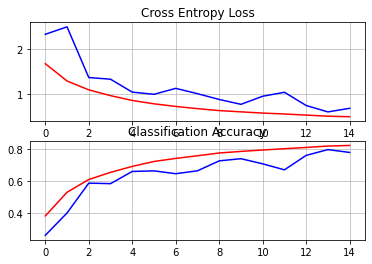

In [16]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 15, model, '15')

In [17]:
epoch_15 = keras.models.load_model('/content/After-15-epochs.h5')

Epoch 1/15
391/391 [==============================] - 89s 221ms/step - loss: 0.4859 - accuracy: 0.8330 - val_loss: 0.7124 - val_accuracy: 0.7783
Epoch 2/15
391/391 [==============================] - 86s 220ms/step - loss: 0.4750 - accuracy: 0.8356 - val_loss: 0.5785 - val_accuracy: 0.8128
Epoch 3/15
391/391 [==============================] - 86s 220ms/step - loss: 0.4586 - accuracy: 0.8409 - val_loss: 0.5249 - val_accuracy: 0.8303
Epoch 4/15
391/391 [==============================] - 86s 219ms/step - loss: 0.4438 - accuracy: 0.8472 - val_loss: 0.5262 - val_accuracy: 0.8299
Epoch 5/15
391/391 [==============================] - 86s 220ms/step - loss: 0.4317 - accuracy: 0.8498 - val_loss: 0.6340 - val_accuracy: 0.7936
Epoch 6/15
391/391 [==============================] - 86s 220ms/step - loss: 0.4168 - accuracy: 0.8563 - val_loss: 0.5195 - val_accuracy: 0.8296
Epoch 7/15
391/391 [==============================] - 86s 219ms/step - loss: 0.4079 - accuracy: 0.8579 - val_loss: 0.7526 - val_ac

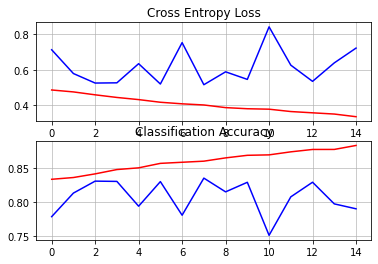

In [18]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 15, epoch_15, '30')

In [19]:
epoch_30 = keras.models.load_model('/content/After-30-epochs.h5')

Epoch 1/15
391/391 [==============================] - 88s 220ms/step - loss: 0.3341 - accuracy: 0.8832 - val_loss: 0.5107 - val_accuracy: 0.8427
Epoch 2/15
391/391 [==============================] - 86s 219ms/step - loss: 0.3260 - accuracy: 0.8863 - val_loss: 1.2036 - val_accuracy: 0.7135
Epoch 3/15
391/391 [==============================] - 86s 219ms/step - loss: 0.3226 - accuracy: 0.8883 - val_loss: 0.5764 - val_accuracy: 0.8263
Epoch 4/15
391/391 [==============================] - 86s 219ms/step - loss: 0.3193 - accuracy: 0.8895 - val_loss: 0.4449 - val_accuracy: 0.8560
Epoch 5/15
391/391 [==============================] - 86s 219ms/step - loss: 0.3054 - accuracy: 0.8933 - val_loss: 0.6589 - val_accuracy: 0.7981
Epoch 6/15
391/391 [==============================] - 86s 219ms/step - loss: 0.3007 - accuracy: 0.8953 - val_loss: 0.4230 - val_accuracy: 0.8705
Epoch 7/15
391/391 [==============================] - 86s 219ms/step - loss: 0.3003 - accuracy: 0.8944 - val_loss: 0.6766 - val_ac

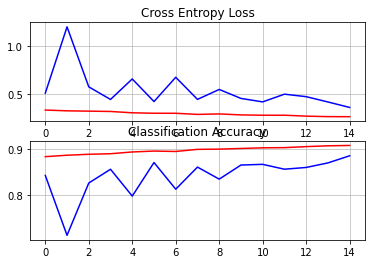

In [20]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 15, epoch_30, '45')

In [21]:
epoch_45 = keras.models.load_model('/content/After-45-epochs.h5')

Epoch 1/15
391/391 [==============================] - 88s 221ms/step - loss: 0.2536 - accuracy: 0.9124 - val_loss: 0.6109 - val_accuracy: 0.8249
Epoch 2/15
391/391 [==============================] - 85s 218ms/step - loss: 0.2572 - accuracy: 0.9092 - val_loss: 0.4101 - val_accuracy: 0.8732
Epoch 3/15
391/391 [==============================] - 86s 219ms/step - loss: 0.2503 - accuracy: 0.9124 - val_loss: 0.5596 - val_accuracy: 0.8406
Epoch 4/15
391/391 [==============================] - 86s 219ms/step - loss: 0.2479 - accuracy: 0.9125 - val_loss: 0.4066 - val_accuracy: 0.8750
Epoch 5/15
391/391 [==============================] - 86s 219ms/step - loss: 0.2420 - accuracy: 0.9149 - val_loss: 0.5514 - val_accuracy: 0.8403
Epoch 6/15
391/391 [==============================] - 86s 219ms/step - loss: 0.2425 - accuracy: 0.9149 - val_loss: 0.3740 - val_accuracy: 0.8813
Epoch 7/15
391/391 [==============================] - 86s 219ms/step - loss: 0.2337 - accuracy: 0.9178 - val_loss: 0.4128 - val_ac

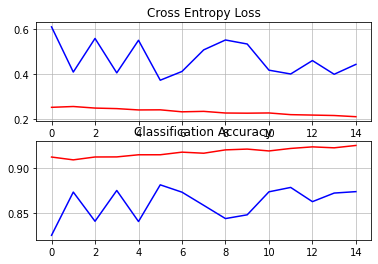

In [22]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 15, epoch_45, '60')

In [23]:
epoch_60 = keras.models.load_model('/content/After-60-epochs.h5')

Epoch 1/25
391/391 [==============================] - 88s 221ms/step - loss: 0.2104 - accuracy: 0.9269 - val_loss: 0.5128 - val_accuracy: 0.8569
Epoch 2/25
391/391 [==============================] - 86s 219ms/step - loss: 0.2106 - accuracy: 0.9263 - val_loss: 0.5307 - val_accuracy: 0.8477
Epoch 3/25
391/391 [==============================] - 86s 219ms/step - loss: 0.2033 - accuracy: 0.9289 - val_loss: 0.3807 - val_accuracy: 0.8858
Epoch 4/25
391/391 [==============================] - 86s 219ms/step - loss: 0.1998 - accuracy: 0.9303 - val_loss: 0.4812 - val_accuracy: 0.8640
Epoch 5/25
391/391 [==============================] - 86s 219ms/step - loss: 0.1991 - accuracy: 0.9309 - val_loss: 0.5667 - val_accuracy: 0.8540
Epoch 6/25
391/391 [==============================] - 86s 219ms/step - loss: 0.1983 - accuracy: 0.9292 - val_loss: 0.6214 - val_accuracy: 0.8334
Epoch 7/25
391/391 [==============================] - 85s 218ms/step - loss: 0.1987 - accuracy: 0.9301 - val_loss: 0.4594 - val_ac

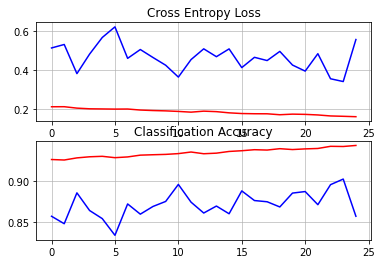

In [24]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 25, epoch_60, '85')

In [25]:
epoch_85 = keras.models.load_model('/content/After-85-epochs.h5')

Epoch 1/25
391/391 [==============================] - 88s 220ms/step - loss: 0.1655 - accuracy: 0.9420 - val_loss: 0.4425 - val_accuracy: 0.8796
Epoch 2/25
391/391 [==============================] - 85s 219ms/step - loss: 0.1538 - accuracy: 0.9465 - val_loss: 0.4212 - val_accuracy: 0.8880
Epoch 3/25
391/391 [==============================] - 86s 219ms/step - loss: 0.1623 - accuracy: 0.9424 - val_loss: 0.3997 - val_accuracy: 0.8855
Epoch 4/25
391/391 [==============================] - 86s 219ms/step - loss: 0.1588 - accuracy: 0.9432 - val_loss: 0.3618 - val_accuracy: 0.9002
Epoch 5/25
391/391 [==============================] - 85s 218ms/step - loss: 0.1550 - accuracy: 0.9456 - val_loss: 0.3659 - val_accuracy: 0.8988
Epoch 6/25
391/391 [==============================] - 85s 218ms/step - loss: 0.1530 - accuracy: 0.9459 - val_loss: 0.4817 - val_accuracy: 0.8730
Epoch 7/25
391/391 [==============================] - 86s 219ms/step - loss: 0.1536 - accuracy: 0.9458 - val_loss: 0.4132 - val_ac

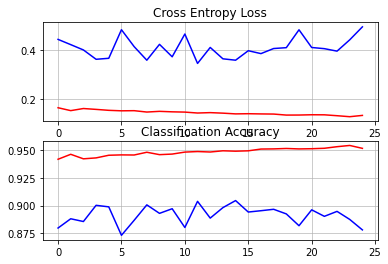

In [26]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 25, epoch_85, '110')

In [27]:
epoch_110 = keras.models.load_model('/content/After-110-epochs.h5')

Epoch 1/30
391/391 [==============================] - 88s 221ms/step - loss: 0.1305 - accuracy: 0.9530 - val_loss: 0.4095 - val_accuracy: 0.8969
Epoch 2/30
391/391 [==============================] - 86s 219ms/step - loss: 0.1273 - accuracy: 0.9546 - val_loss: 0.3737 - val_accuracy: 0.8963
Epoch 3/30
391/391 [==============================] - 85s 218ms/step - loss: 0.1308 - accuracy: 0.9533 - val_loss: 0.3288 - val_accuracy: 0.9093
Epoch 4/30
391/391 [==============================] - 85s 218ms/step - loss: 0.1292 - accuracy: 0.9546 - val_loss: 0.6810 - val_accuracy: 0.8413
Epoch 5/30
391/391 [==============================] - 85s 218ms/step - loss: 0.1255 - accuracy: 0.9557 - val_loss: 0.4017 - val_accuracy: 0.8944
Epoch 6/30
391/391 [==============================] - 85s 218ms/step - loss: 0.1278 - accuracy: 0.9549 - val_loss: 0.5129 - val_accuracy: 0.8726
Epoch 7/30
391/391 [==============================] - 85s 218ms/step - loss: 0.1256 - accuracy: 0.9559 - val_loss: 0.4347 - val_ac

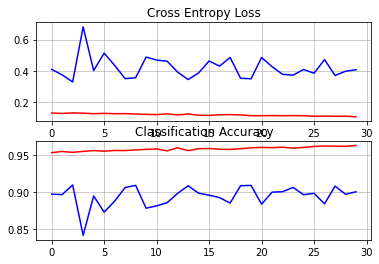

In [28]:
run_test_harness(X_train, X_test, y_train, y_test, 128, 25, epoch_110, '135')

In 125th epoech val_accuracy is 90.87% & after running the model another 10 epoch to 135th epoch no improvement is seen. Thus the maximum val_accuracy I got is 90.87